#Plasmid stability 
## Different fractions of plasmid bearing strain were mixed with WT strain.
## Each fraction were submitted to different antibiotic concentration and the resulting fraction was stimated.

## Prepare file system

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
import os
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
import sys

### Mount Gdrive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Set paths

In [3]:
project_path="/content/drive/My Drive/SYNC_Projects/Plasmidia/ms/"   ####  <-------------------- check


figures_path=project_path+"figures/"
table_path=project_path+"data/parameters/"
data_path=table_path
dfs_path=project_path+"data/experimental_dataframes/"
code_path=project_path+"code/"
sys.path.insert(0, code_path)

reps=["rep-1","rep-2","rep-3","rep-4"]
hours=["16h","24h"]      

freqs=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1, 'x']
cols=[x for x in np.arange(1,13)]

freqs_dict=dict(zip(cols,freqs))

print(freqs_dict)
rows="A B C D E F G H"
rows=rows.split()
amps=[0,1,2,2.5,3,3.5,4,6]
amp_dict=dict(zip(rows,amps))

print(amp_dict)


{1: 0, 2: 0.1, 3: 0.2, 4: 0.3, 5: 0.4, 6: 0.5, 7: 0.6, 8: 0.7, 9: 0.8, 10: 0.9, 11: 1, 12: 'x'}
{'A': 0, 'B': 1, 'C': 2, 'D': 2.5, 'E': 3, 'F': 3.5, 'G': 4, 'H': 6}


### Load growth rate parameters


In [5]:
from model import *
from plotting import *

## Loading dataframes

In [6]:
file=dfs_path+"ratioLocalDbg.csv"
df_ratioLocalDbg=pd.read_csv(file,sep=",",index_col=0)

file=dfs_path+"ONratioLocalDbg.csv"
df_ONratioLocalDbg=pd.read_csv(file,sep=",",index_col=0)

file=dfs_path+"ratioLocal.csv"
df_ratioLocal=pd.read_csv(file,sep=",",index_col=0)

file=dfs_path+"ratio.csv"
df_ratio=pd.read_csv(file,sep=",",index_col=0)

file=dfs_path+"odDbg.csv"
df_odDbg=pd.read_csv(file,sep=",",index_col=0)

file=dfs_path+"GfpDbg.csv"
df_gfpDbg=pd.read_csv(file,sep=",",index_col=0)

## Inoculation plate normalization


/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  fig.canvas.print_figure(bytes_io, **kw)


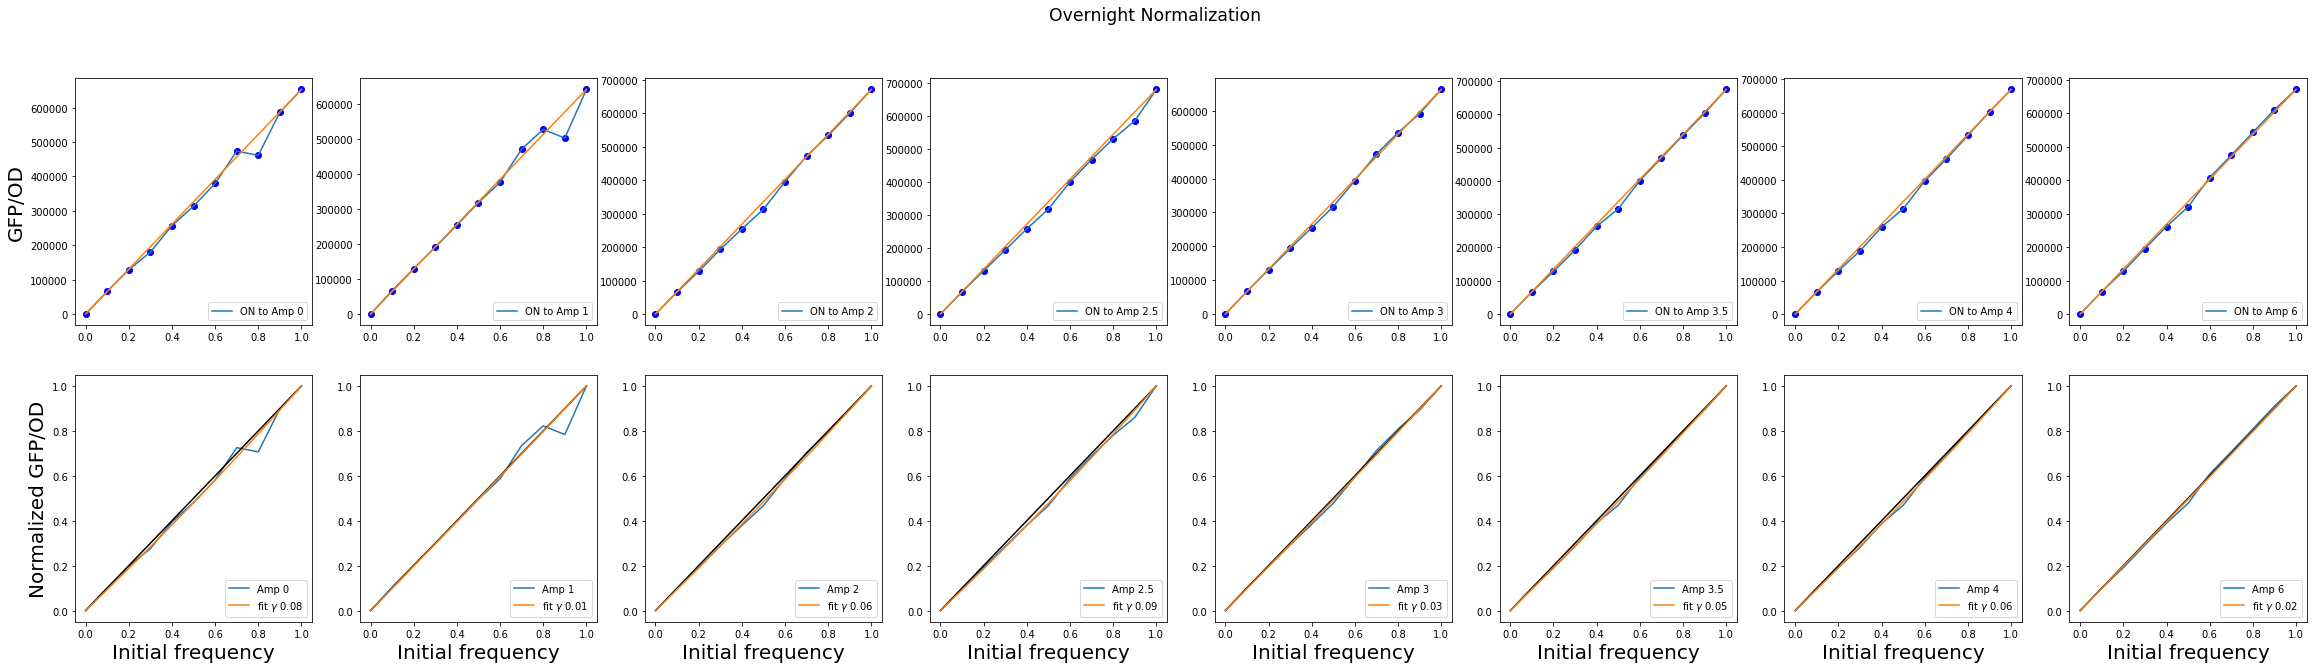

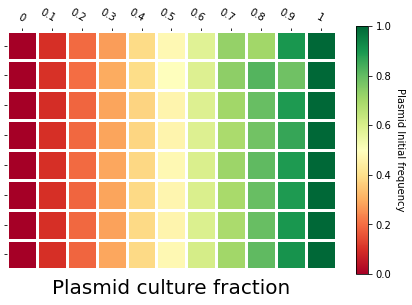

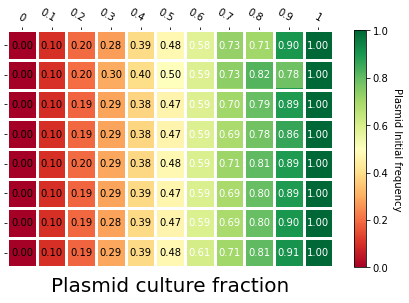

In [7]:
freqs=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
cols=[x for x in np.arange(1,12)]
freqs_dict=dict(zip(cols,freqs))

fig,axs=plt.subplots(2,len(rows),figsize=(5*len(rows),10))

this_df=df_ONratioLocalDbg.copy()
#this_df=df_ONgfpDbg.copy()
#this_df=df_ONratioLocal.copy()

df_ONiniFreqs=this_df.copy()

mtxON=[]
gammasON=[]
on_points=[]
on_points01=[]
for ri,r in enumerate(amp_dict.keys()):
    amp=amp_dict[r]
    ys_mtx=[]
    freqs=[]
    ys=[]
    for ci,c in enumerate(freqs_dict.keys()):
        freq=freqs_dict[c]
        freqs.append(freq)
        this_key=r+str(c)
        val=this_df[this_key][0]
        on_points.append((freq,val))
        axs[0,ri].scatter(freq,val,c='b')

        ys.append(val)
    ys_mtx.append(ys)
    axs[0,ri].plot(freqs,ys,label="ON to Amp %s"%(amp))
    axs[0,ri].plot([0,1],[ys[0],ys[-1]])
 
    
    axs[0,ri].legend(loc=4)
    
    y_min=ys[0]
    
    y_max=ys[-1]
    
    ys2=(ys-y_min)/(y_max-y_min)
           
    mtxON.append(ys2)
    #print(amp,freqs,ys2)
    for ci,c in enumerate(freqs_dict.keys()):
        this_key=r+str(c)
        val=ys2[ci]
        df_ONiniFreqs[this_key]=val
        on_points01.append((freqs_dict[c],val))
    axs[1,ri].plot(freqs,ys2,label="Amp %s"%amp)
    axs[1,ri].plot([0,1],[0,1],c='K')
    
    
    freqsnp=np.asarray(freqs)
    
    popt, pcov = curve_fit(f0, freqs, ys2,bounds=([0,mu_n*0.9999],[1,mu_n*1.0001]))
    #print(popt)
    gammaON=popt[0]
    #print(gammaON)
    gammasON.append(gammaON)    
    axs[1,ri].plot(freqs,f0(freqsnp,gammaON,mu_n),label="fit $\gamma$ %s"%round(gammaON,2))
    
        
    
   # xs0,ys0=make_cobweb(p,.5)
   # axs[1,ri].plot(xs0,ys0,'b--',alpha=.3)

    axs[1,ri].set_xlabel("Initial frequency",fontsize=20)
    axs[1,ri].legend(loc=4)
    

axs[0,0].set_ylabel("GFP/OD",fontsize=20)
axs[1,0].set_ylabel("Normalized GFP/OD",fontsize=20)
plt.suptitle("Overnight Normalization",size='xx-large')
figName=figures_path+"Inoculum_normalization.png"
#plt.savefig(figName)
plt.show()

mtxON=np.ascontiguousarray(mtxON)

fig, ax = plt.subplots()
im, cbar = heatmap(mtxON, [], freqs_dict.values(), ax=ax,cmap="RdYlGn", cbarlabel="Plasmid Initial frequency")
fig.tight_layout()
plt.xlabel("Plasmid culture fraction",fontsize=20)
figName=figures_path+"Inoculum_Matrix.png"
#plt.savefig(figName)
plt.show()


fig, ax = plt.subplots()

im, cbar = heatmap(mtxON, [], freqs_dict.values(), ax=ax,cmap="RdYlGn", cbarlabel="Plasmid Initial frequency")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

plt.xlabel("Plasmid culture fraction",fontsize=20)
fig.tight_layout()
figName=figures_path+"Inoculum_Matrix-text.png"
#plt.savefig(figName)

plt.show()


    

### Correlation Freqs vs Fluorescence

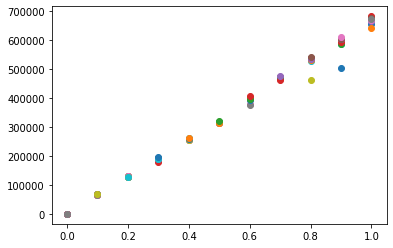

0.9951597422215736
intercept: -3826.977272727294
slope: [662376.81818182]


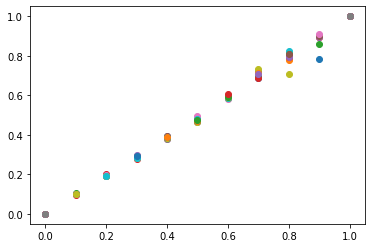

0.9963776227848392
intercept: -0.005654010326829495
slope: [0.99503586]


In [8]:
from sklearn.linear_model import LinearRegression

xs=[]
ys=[]
for p in on_points:
    x=p[0]
    y=p[1]
    xs.append(x)
    ys.append(y)
    plt.scatter(x,y)
plt.show()


xs=np.array(xs).reshape((-1, 1))
model = LinearRegression().fit(xs, ys)
r_sq = model.score(xs, ys)
print(r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)
xs=[]
ys=[]
for p in on_points01:
    x=p[0]
    y=p[1]
    xs.append(x)
    ys.append(y)
    plt.scatter(x,y)
plt.show()


xs=np.array(xs).reshape((-1, 1))
model = LinearRegression().fit(xs, ys)
r_sq = model.score(xs, ys)
print(r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)


## Data normalization

### Replicate GFP/OD view   (data to normalize)


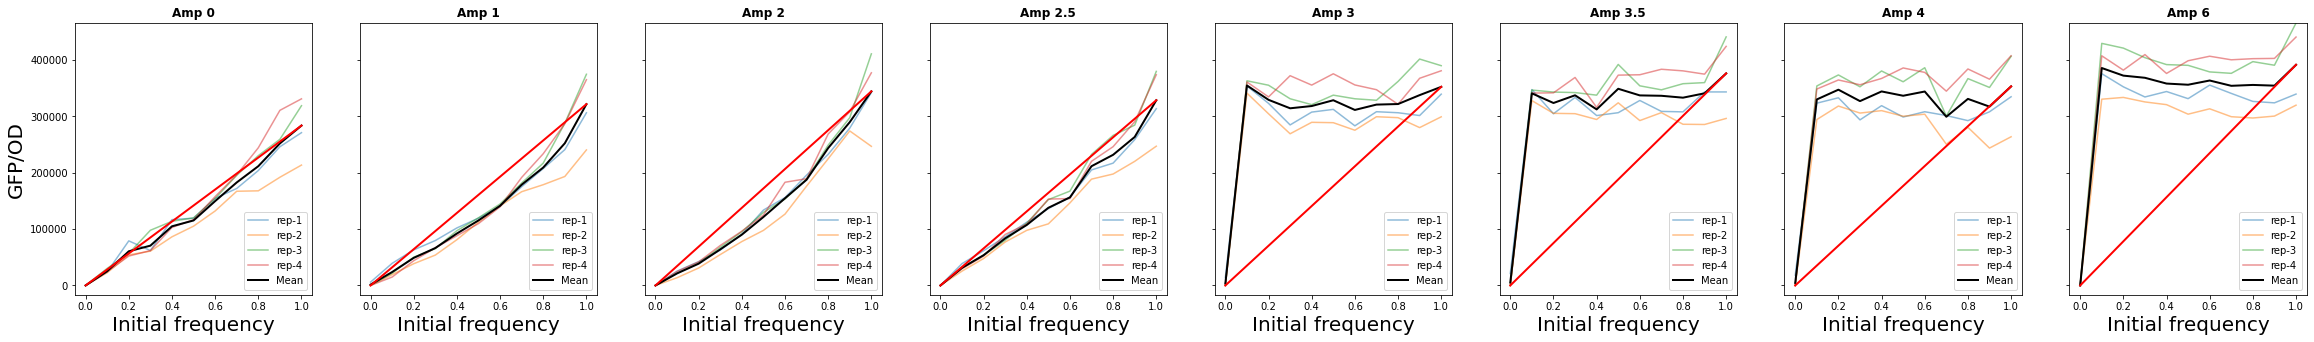

In [9]:
freqs=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
cols=[x for x in np.arange(1,12)]
freqs_dict=dict(zip(cols,freqs))
fig,axs=plt.subplots(1,len(rows),figsize=(5*len(rows),5),sharey=True)

this_df=df_ratioLocalDbg.copy()


mtx=[]
mtxI=[]
polys=[]
polysI=[]
ymax=0
alphas=[]
alphasI=[]
for ri,r in enumerate(amp_dict.keys()):
    amp=amp_dict[r]
    ys_mtx=[]
    hr=24
#     if(amp==0):
#         hr=16
    #print(amp,hr)
    for rep in reps:
        freqs=[]
        
        ys=[]
        for ci,c in enumerate(freqs_dict.keys()):
            freq=freqs_dict[c]
            freqs.append(freq)
            this_key=r+str(c)
            val=this_df[(this_df["Rep"]==rep)&(this_df["Time"]==hr)][this_key].to_numpy()[0]
            ys.append(val)
            if(val>ymax):
                ymax=val
        ys_mtx.append(ys)
        axs[ri].plot(freqs,ys,alpha=.5,label=rep)
        axs[ri].set_title("Amp %s"%amp,fontweight='bold')
    
    ms=[]
    for fi,freq in enumerate(freqs):
        col=[r[fi] for r in ys_mtx]
        m=np.mean(col)
        ms.append(m)
        if(ri==0 and fi==0):
            #print("x")
            y_minA=m
        if(ri==0 and fi==10):
            #print("xx")
            y_maxA=m
    axs[ri].plot(freqs,ms,c='k',lw=2,label="Mean")
    
    axs[ri].plot([0,1],[0,ms[-1]],c='r',lw=2,)
    axs[ri].legend(loc=4)
    axs[ri].set_xlabel("Initial frequency",fontsize=20)
    
    axs[ri].set_ylim(ymax=ymax)
    
    
axs[0].set_ylabel("GFP/OD",fontsize=20) 
figName=figures_path+"Experiment_raw_GFP-OD.png"
#plt.savefig(figName)
 
plt.show()

## normalization using expected initial frquencies

xx
kkkkkkk 0 0.0
Amp:0	freqs:[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]-[0.0, 0.0748088427132454, 0.15392602580689702, 0.23773476889069609, 0.32666512926956554, 0.42120138320048056, 0.5218908484514244, 0.6293544875495564, 0.7442997256179946, 0.8675360418904546, 0.9999940613383008]
kkkkkkk 1 1488.25
Amp:1	freqs:[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]-[0.0, 0.05543256791178703, 0.11664108614296326, 0.18457793438698597, 0.2604170498279882, 0.34562233328817044, 0.4420430679891821, 0.5520496723825911, 0.6787311856213911, 0.8261899226912321, 0.9999940613383008]
kkkkkkk 2 0.0
Amp:2	freqs:[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]-[0.0, 0.05720309929272665, 0.12011801871265655, 0.18964521575248486, 0.26688491964543515, 0.35319578519422534, 0.45027550099581676, 0.5602735771824103, 0.685952368344747, 0.8309222451716388, 0.9999940613383007]
kkkkkkk 2.5 0.0
Amp:2.5	freqs:[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]-[0.0, 0.07097050164274189, 0.1466718343478633,

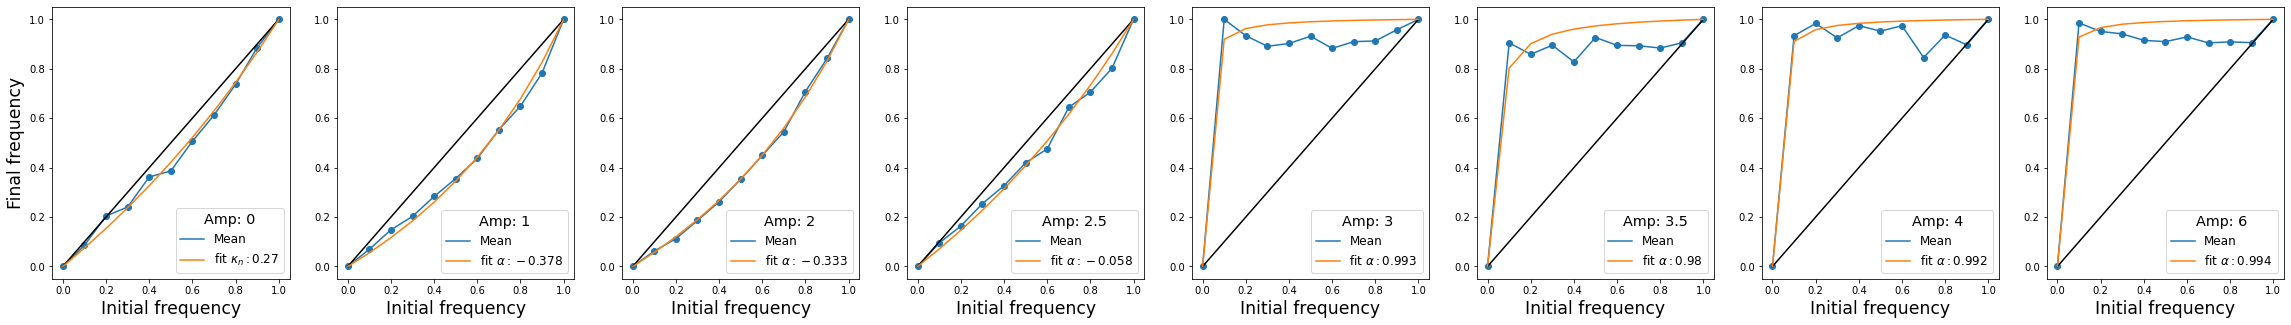

Fitting values
0.27227589582571493 [0.0, -0.37781049928627075, -0.33266226783986735, -0.05845671728600112, 0.9929108533618389, 0.9800999023208216, 0.9920750198502178, 0.9937303523498018]


In [11]:
fig,axs=plt.subplots(1,len(rows),figsize=(5*len(rows),5))
freqs=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
cols=[x for x in np.arange(1,12)]
freqs_dict=dict(zip(cols,freqs))


this_df=df_ratioLocalDbg.copy()
mtx=[]

ymax=0
alphas3=[]

for ri,r in enumerate(amp_dict.keys()):
    amp=amp_dict[r]
    ys_mtx=[]
    hr=24
#     if(amp==0):
#         hr=16
    #print(amp,hr)
    for rep in reps:
        if(ri==0 and rep=='rep-2'):
           continue
        freqs=[]
        ys=[]
        for ci,c in enumerate(freqs_dict.keys()):
            freq=freqs_dict[c]
            freqs.append(freq)
            this_key=r+str(c)
            val=this_df[(this_df["Rep"]==rep)&(this_df["Time"]==hr)][this_key].to_numpy()[0]
            ys.append(val)
            if(val>ymax):
                ymax=val
        ys_mtx.append(ys)
        
    ms=[]
    for fi,freq in enumerate(freqs):
        col=[r[fi] for r in ys_mtx]
        m=np.mean(col)
        ms.append(m)
        if(ri==0 and fi==0):
            #print("x")
            y_minA=m
        if(ri==0 and fi==10):
            print("xx")
        y_maxA2=np.max(col)
 
    y_min=y_minA
    y_max=ms[-1]
 
    gr_threshold=ms[0]
    if(gr_threshold<1000000):
        print("kkkkkkk",amp,gr_threshold)
        y_min=ms[0]
        
        ys2=[(x-y_min)/(y_max-y_min) for x in ms]
        for yi,y in enumerate(ys2):
            if(y>1):
                print("Value greater than 1* Amp:%s, val: %s"%(amp,y))
                ys2[yi]=1
                #print(amp,yi)
        ys2[-1]=1               ###33 <<<<<<<<< sheep
        mtx.append(ys2)
        
        
    else:
        print("kkkkkkk",amp,gr_threshold)
        ys2=(ms-y_min)/(y_max-y_min)
        ys2[0]=0
        for yi,y in enumerate(ys2):
            if(y>1):
                print("Value greater than 1* Amp:%s, val: %s"%(amp,y))
                ys2[yi]=1
                #print(amp,yi)
        mtx.append(ys2)
        mtxI.append(ys2) 
        y_max=max_Y
        ys2=ys2[1:]
        freqs=freqs[1:]
        freqsInit=freqsInit[1:]
    #print(amp,freqs,ys2)
    axs[ri].plot(freqs,ys2,label="Mean")
    axs[ri].scatter(freqs,ys2)
    axs[ri].set_xlabel("Initial frequency",size='xx-large')
    #axs[ri].set_title("Amp: %s"%amp,size='xx-large')
    
    axs[ri].plot([0,1],[0,1],c='K')
    freqsnp=np.asarray(freqs)
    ################FIT PARAMS ####################
    if(ri==0):
        popt, pcov = curve_fit(f0, freqs, ys2,bounds=([0,mu_n*0.9999],[1,mu_n*1.0001]))
        gamma3=popt[0]
        alpha=0.
        axs[ri].plot(freqs,f0(freqsnp,gamma3,mu_n),label=r"fit $\kappa_n:$%s"%round(gamma3,2))
    else:
        popt, pcov = curve_fit(f1, freqs, ys2,bounds=([gamma3*0.9999,-1,mu_n*0.9999],[gamma3*1.0001,1,mu_n*1.0001]))
        alpha=popt[1]
        axs[ri].plot(freqs,f1(freqsnp,gamma3,alpha,mu_n),label=r'fit $ \alpha:%s $ '%(round(alpha,3)))
    
    alphas3.append(alpha)
    axs[ri].legend (loc=4,title="Amp: %s"%amp,title_fontsize='x-large',fontsize='large')
    ys2=[x for x in list(f1(freqsnp,gamma3,alpha,mu_n))]
    print("Amp:%s\tfreqs:%s-%s"%(amp,freqs,ys2))
axs[0].set_ylabel("Final frequency",size='xx-large')

figName=figures_path+"Fig-X_DataNormalization.png"
#plt.savefig(figName,bbox_inches = 'tight',pad_inches = 0.1)
plt.show()

plt.legend

print("Fitting values")
print(gamma3,alphas3)


## Save fitting parameters 

In [12]:
amps=np.array(list(amp_dict.values()))
ampsx=[round(x,6) for x in amps]
gammaEx=round(gamma3,6)
alphasEx=[round(x,6) for x in alphas3]
table=pd.DataFrame({"Amp":ampsx,"κ_n":[gammaEx]*len(amps),"⍺":alphasEx})
table.to_csv(table_path+"alphas_table.csv",sep=",",index=False,index_label=False)
tablel=pd.DataFrame({"Amp":ampsx,"$\kappa_n$":[gammaEx]*len(amps),"$\\alpha$":alphasEx})
tablel.to_csv(table_path+"alphas_table_latex.csv",sep=",",index=False,index_label=False)

tablel

,Amp,$\kappa_n$,$\alpha$
0,0.0,0.272276,0.000000
1,1.0,0.272276,-0.377810
2,2.0,0.272276,-0.332662
3,2.5,0.272276,-0.058457
4,3.0,0.272276,0.992911
5,3.5,0.272276,0.980100
6,4.0,0.272276,0.992075
7,6.0,0.272276,0.993730
